In [1]:
from ClipEmbeddingsGenerator import ClipEmbeddingsGenerator, draw_images
import pymilvus 
import glob


/Users/vramos/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/vramos/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setup

Hacer embeddings de las imágenes

In [ ]:
model = ClipEmbeddingsGenerator()
paths = glob.glob('./avatars/*.png')
embedded_images = model.embedd_images(paths)

data = [{'id': int(path.split('\\')[-1].split('.')[0].replace('-', '')), 'image_path': path, 'embedding': embedding} for path, embedding in zip(paths, embedded_images)]


Si la base de datos no existe, crearla

In [ ]:
from pymilvus import connections

connections.connect(host='localhost', port='19530')

print(connections.list_databases())

In [ ]:
if 'dungeons' not in connections.list_databases():
    connections.create_database('dungeons')

connections.disconnect()

Conectamos a la base de datos

In [60]:
from pymilvus import connections, db

conn = connections.connect(host="localhost", port=19530, database='dungeons')

Creamos el cliente

In [2]:
from pymilvus import MilvusClient

client = MilvusClient(host="localhost", port=19530, database='dungeons')


Creamos el schema para la colección de avatares

In [82]:
# 3. Create a collection in customized setup mode

# 3.1. Create schema
schema = MilvusClient.create_schema(
    auto_id=False,
    enable_dynamic_field=True,
)

schema.add_field(field_name="id", datatype=pymilvus.DataType.INT64, is_primary=True)
schema.add_field(field_name="image_path", datatype=pymilvus.DataType.VARCHAR, max_length=256)
schema.add_field(field_name="embedding", datatype=pymilvus.DataType.FLOAT_VECTOR, dim=512)



{'auto_id': False, 'description': '', 'fields': [{'name': 'id', 'description': '', 'type': <DataType.INT64: 5>, 'is_primary': True, 'auto_id': False}, {'name': 'image_path', 'description': '', 'type': <DataType.VARCHAR: 21>, 'params': {'max_length': 256}}, {'name': 'embedding', 'description': '', 'type': <DataType.FLOAT_VECTOR: 101>, 'params': {'dim': 512}}], 'enable_dynamic_field': True}

Creamos un índice para acelerar la búsqueda

In [83]:
# 3.3. Prepare index parameters
index_params = client.prepare_index_params()

# 3.4. Add indexes
index_params.add_index(
    field_name="id",
    index_type="STL_SORT"
)

index_params.add_index(
    field_name="embedding", 
    index_type="IVF_FLAT",
    metric_type="COSINE",
    params={ "nlist": 128 }
)

Creamos la colección

In [84]:
import time

client.create_collection(
    collection_name="avatars",
    schema=schema,
    index_params=index_params
)

time.sleep(5)

res = client.get_load_state(
    collection_name="avatars"
)

print(res)

{'state': <LoadState: Loaded>}


In [3]:
from pprint import pprint
res = client.describe_collection(
    collection_name="avatars"
)

pprint(res)

{'aliases': [],
 'auto_id': False,
 'collection_id': 448982854545350067,
 'collection_name': 'avatars',
 'consistency_level': 2,
 'description': '',
 'enable_dynamic_field': True,
 'fields': [{'description': '',
             'field_id': 100,
             'is_primary': True,
             'name': 'id',
             'params': {},
             'type': <DataType.INT64: 5>},
            {'description': '',
             'field_id': 101,
             'name': 'image_path',
             'params': {'max_length': 256},
             'type': <DataType.VARCHAR: 21>},
            {'description': '',
             'field_id': 102,
             'name': 'embedding',
             'params': {'dim': 512},
             'type': <DataType.FLOAT_VECTOR: 101>}],
 'num_partitions': 1,
 'num_shards': 1,
 'properties': {}}


Insertamos los datos

In [88]:
res = client.insert(
    collection_name="avatars",
    data=data
)

Probamos la búsqueda

In [92]:
res = client.search(
    collection_name="avatars", # Replace with the actual name of your collection
    # Replace with your query vector
    data=[embedded_images[0]],
    limit=5, # Max. number of search results to return
    search_params={"metric_type": "COSINE", "params": {}}, # Search parameters
    output_fields=["image_path"] 
)

pprint(res)

[[{'distance': 0.9999997019767761,
   'entity': {'image_path': './avatars\\00000-468694721.png'},
   'id': 468694721},
  {'distance': 0.8881928324699402,
   'entity': {'image_path': './avatars\\00008-1945072424.png'},
   'id': 81945072424},
  {'distance': 0.8693963289260864,
   'entity': {'image_path': './avatars\\00034-2395602461.png'},
   'id': 342395602461},
  {'distance': 0.8586881756782532,
   'entity': {'image_path': './avatars\\00016-1300628933.png'},
   'id': 161300628933},
  {'distance': 0.8583647608757019,
   'entity': {'image_path': './avatars\\00100-802584388.png'},
   'id': 100802584388}]]


## Queries

In [ ]:
from pymilvus import MilvusClient

client = MilvusClient(host="localhost", port=19530, database='dungeons')

In [41]:
model_for_query = ClipEmbeddingsGenerator()

text = 'A man with white hair, blue eyes, young and handsome'
image_path = './keanu.jpg'
#embedded_vector = model_for_query.embedd_images([image_path])
embedded_vector = model_for_query.embedd_texts([text])

#draw_images([image_path], ['original photo'])

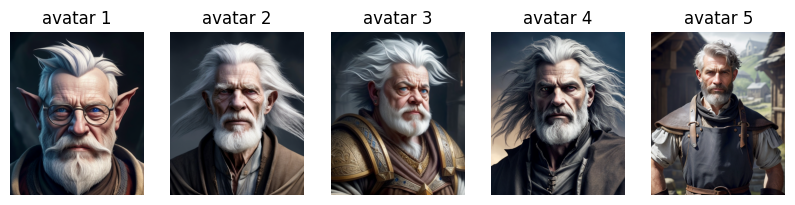

In [42]:
limit = 5

res = client.search(
    collection_name="avatars", # Replace with the actual name of your collection
    # Replace with your query vector
    data=embedded_vector,
    limit=limit, # Max. number of search results to return
    search_params={"metric_type": "COSINE", "params": {}}, # Search parameters
    output_fields=["image_path"] 
)

draw_images([res[0][i]['entity']['image_path'] for i in range(limit)], [f'avatar {i+1}' for i in range(limit)])